In [47]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, learning_curve
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score, balanced_accuracy_score

# Model preparation

## Import data for model training and testing

In [48]:
labels = pd.read_csv('./../labels/labels_v1/labels_v1.csv', index_col=0)
genomic_features = pd.read_csv('./../models/model_logistic_regression_v4/manually_selected_features_frac.csv', index_col=0)

## Merge features and labels

In [49]:
complete_data = pd.merge(genomic_features, labels, on='SAMPLE_ID', how='inner')
complete_data = complete_data.drop(columns=['Unnamed: 0'], errors='ignore')
complete_data = complete_data.set_index('SAMPLE_ID', inplace=False)

## Model training - logistic regression

#### Train/Test split

In [50]:
columns_to_drop = ['labels_v1']
X = complete_data.drop(columns_to_drop, axis=1) # features definition
y = complete_data['labels_v1'] # labels definition
original_indices = X.index

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, original_indices, test_size=0.3, random_state=42)

#### Features normalization

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X.shape)
print(y.shape)

(196, 58)
(196,)


#### Model training

In [52]:
model = LogisticRegression()
model.fit(X_train, y_train)

evaluation_criteria = {
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'average_precision': 'average_precision',
    'recall': 'recall',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy',
    'positive_likelihood_ratio': 'positive_likelihood_ratio'
}

scores = cross_validate(model, X, y, cv=5, scoring=evaluation_criteria)

for metric in evaluation_criteria:
    print(f"{metric}: {scores['test_' + metric]}")
    print(f"Mean {metric}: {scores['test_' + metric].mean()}")
    print(f"Std {metric}: {scores['test_' + metric].std()}\n")

roc_auc: [0.58933333 0.45142857 0.60571429 0.75277778 0.77222222]
Mean roc_auc: 0.6342952380952381
Std roc_auc: 0.11776300493498679

precision: [0.71428571 0.68421053 0.72727273 0.64705882 0.73333333]
Mean precision: 0.7012322249473952
Std precision: 0.031948327500406506

average_precision: [0.70437455 0.65156503 0.73035218 0.84685573 0.79826647]
Mean average_precision: 0.7462827916980466
Std average_precision: 0.06899095518183465

recall: [0.8        0.52       0.64       0.91666667 0.91666667]
Mean recall: 0.7586666666666666
Std recall: 0.15663971399361018

f1: [0.75471698 0.59090909 0.68085106 0.75862069 0.81481481]
Mean f1: 0.7199825280681882
Std f1: 0.07730947683637289

balanced_accuracy: [0.63333333 0.54571429 0.60571429 0.55833333 0.69166667]
Mean balanced_accuracy: 0.606952380952381
Std balanced_accuracy: 0.05289218057936266

positive_likelihood_ratio: [1.5        1.21333333 1.49333333 1.14583333 1.71875   ]
Mean positive_likelihood_ratio: 1.41425
Std positive_likelihood_ratio:

/home/klaudiautm/PycharmProjects/final_project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/klaudiautm/PycharmProjects/final_project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

## Model test

In [53]:
y_pred = model.predict(X_test)

y_pred_list = pd.DataFrame(y_pred, columns=['Predicted'], index=idx_test)

### Model evaluation

AUC: 0.719047619047619
Accuracy: 0.7288135593220338
Balanced accuracy: 0.719047619047619
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        24
           1       0.77      0.77      0.77        35

    accuracy                           0.73        59
   macro avg       0.72      0.72      0.72        59
weighted avg       0.73      0.73      0.73        59

Confusion Matrix:
[[16  8]
 [ 8 27]]


<Axes: >

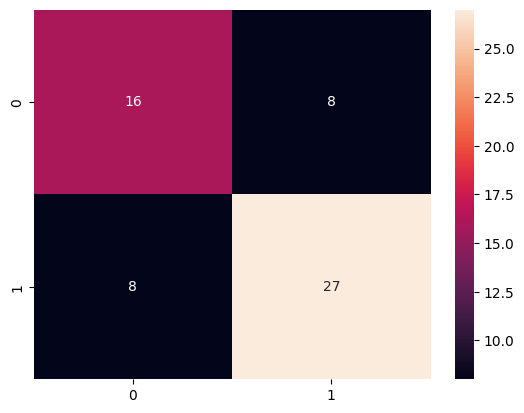

In [54]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Balanced accuracy: {balanced_acc}")
print("Classification Report:")
print(cr)
print("Confusion Matrix:")
print(cm)

import seaborn as sns
sns.heatmap(cm, annot=True)

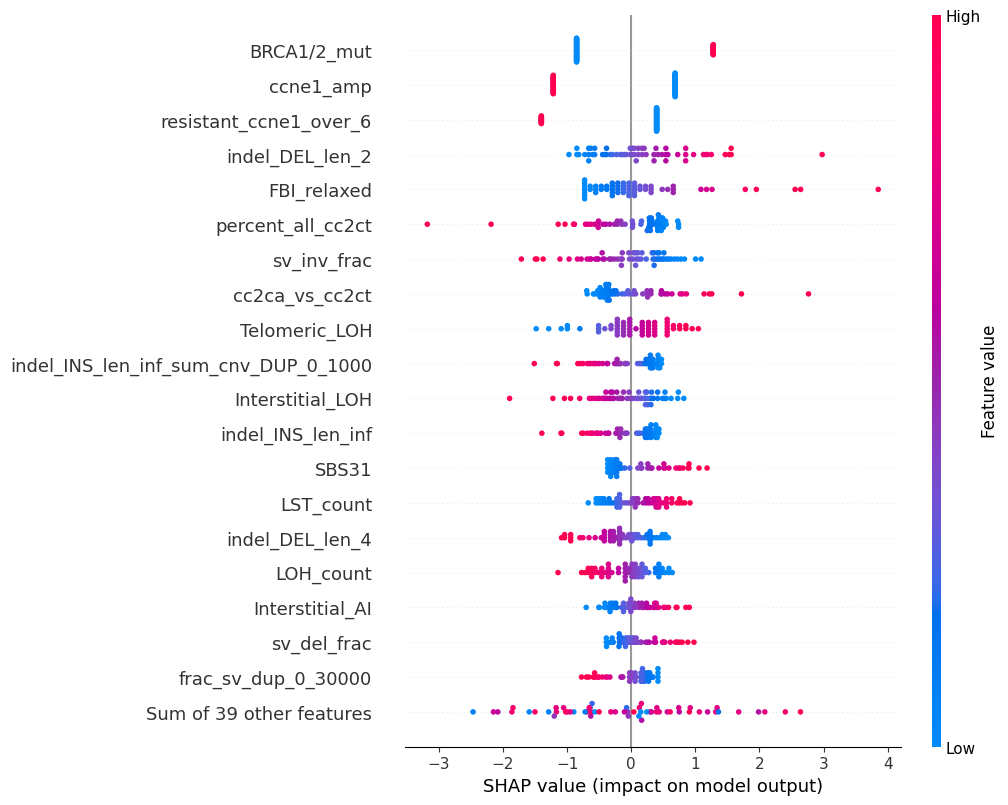

In [55]:
import shap

original_feature_names = ['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'Interstitial_LOH', 'LST_count', 'LOH_count', 'MSI', 'cnv_DEL_0_3500_sum_indel_DEL_len_inf', 'indel_INS_len_inf_sum_cnv_DUP_0_30000', 'indel_INS_len_inf_sum_cnv_DUP_0_1000', 'frac_cnv_DUP_len_30000_inf', 'frac_cnv_DEL_len_100000_inf', 'frac_cnv_DIPLOID_len_100000_inf', 'frac_sv_dup_30000+', 'frac_sv_del_frac', 'frac_sv_del_100000+', 'FBI_relaxed', 'percent_all_cc2ca', 'percent_all_cc2ct', 'cc2ca_vs_cc2ct', 'SBS31', 'ccne1_amp', 'resistant_ccne1_over_6', 'frac_cnv_DUP_len_0_30000', 'frac_cnv_DEL_len_0_100000', 'frac_cnv_DIPLOID_len_0_100000', 'frac_sv_dup_0_30000', 'frac_sv_del_0_100000']
X_train_features = pd.DataFrame(X_train, columns=original_feature_names)
X_test_features = pd.DataFrame(X_test, columns=original_feature_names)

explainer = shap.Explainer(model, X_train_features)
shap_values = explainer(X_test_features)
shap.plots.beeswarm(shap_values, max_display=20)

# Save final model

In [56]:
joblib.dump(model, 'final_model_for_parpi_response_prediction')

['final_model_for_parpi_response_prediction']